In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from random import sample
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.models import Model
from pathlib import Path
Image.LOAD_TRUNCATED_IMAGES = True
import requests
from io import BytesIO
import os

In [2]:
# Read the data files
listing_data = pd.read_csv("data/current_farfetch_listings.csv")

In [3]:
listing_data.head()

Unnamed: 0                                     availableSizes  brand.id  \
0           0                                                NaN      8360   
1           1  [{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...   2049368   
2           2                                                NaN     15514   
3           3               [{'scaleId': 0, 'size': 'One Size'}]     49486   
4           4                                                NaN     34624   

      brand.name gender  hasSimilarProducts        id  \
0        Miu Miu  women                True  13415450   
1  Self-Portrait  women                True  13784566   
2          Fendi  women                True  13377441   
3         A.P.C.  women               False  13744082   
4          Prada  women                True  13668256   

                                       images.cutOut  \
0  https://cdn-images.farfetch-contents.com/13/41...   
1  https://cdn-images.farfetch-contents.com/13/78...   
2  https://cdn-images.farfetch-contents.com/13/37...   
3  https://cdn-images.farfetch-contents.com/13/74...   
4  https://cdn-images.farfetch-contents.com/13/66...   

                                        images.model  isCustomizable  ...  \
0  https://cdn-images.farfetch-contents.com/13/41...           False  ...   
1  https://cdn-images.farfetch-contents.com/13/78...           False  ...   
2  https://cdn-images.farfetch-contents.com/13/37...           False  ...   
3  https://cdn-images.farfetch-contents.com/13/74...           False  ...   
4  https://cdn-images.farfetch-contents.com/13/66...           False  ...   

  priceInfo.currencyCode priceInfo.discountLabel  priceInfo.finalPrice  \
0                    SGD                     NaN                  1080   
1                    SGD                 20% Off                   392   
2                    SGD                     NaN                  1245   
3                    SGD                 20% Off                   308   
4                    SGD                     NaN                  1248   

  priceInfo.formattedFinalPrice priceInfo.formattedInitialPrice  \
0                        $1,080                          $1,080   
1                          $392                            $490   
2                        $1,245                          $1,245   
3                          $308                            $385   
4                        $1,248                          $1,248   

   priceInfo.initialPrice priceInfo.installmentsLabel priceInfo.isOnSale  \
0                    1080                         NaN              False   
1                     490                         NaN               True   
2                    1245                         NaN              False   
3                     385                         NaN               True   
4                    1248                         NaN              False   

                 shortDescription  stockTotal  
0       logo print strap sandals          130  
1          embroidered midi dress          14  
2  FendiMania sock style sneakers          68  
3                  top zip wallet           1  
4              slingback 65 pumps          78  

[5 rows x 23 columns]

In [4]:
listing_data.shape

(188817, 23)

In [5]:
listing_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188817 entries, 0 to 188816
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   availableSizes                   162711 non-null  object 
 1   brand.id                         188817 non-null  int64  
 2   brand.name                       188817 non-null  object 
 3   gender                           188817 non-null  object 
 4   hasSimilarProducts               188817 non-null  bool   
 5   id                               188817 non-null  int64  
 6   images.cutOut                    188817 non-null  object 
 7   images.model                     188817 non-null  object 
 8   isCustomizable                   188817 non-null  bool   
 9   merchandiseLabel                 56441 non-null   object 
 10  merchandiseLabelField            188817 non-null  object 
 11  merchantId                       188817 non-null  int64  
 12  pr

In [7]:
listing_data.drop('priceInfo.installmentsLabel', axis=1, inplace=True)

In [8]:
# Check for % of null values
listing_data.isnull().sum() * 100 / listing_data.shape[0] 

availableSizes                     13.826086
brand.id                            0.000000
brand.name                          0.000000
gender                              0.000000
hasSimilarProducts                  0.000000
id                                  0.000000
images.cutOut                       0.000000
images.model                        0.000000
isCustomizable                      0.000000
merchandiseLabel                   70.108094
merchandiseLabelField               0.000000
merchantId                          0.000000
priceInfo.currencyCode              0.000000
priceInfo.discountLabel            63.834295
priceInfo.finalPrice                0.000000
priceInfo.formattedFinalPrice       0.000000
priceInfo.formattedInitialPrice     0.000000
priceInfo.initialPrice              0.000000
priceInfo.isOnSale                  0.000000
shortDescription                    0.000000
stockTotal                          0.000000
dtype: float64

In [9]:
# Analyse the null variables
listing_data[~listing_data['merchandiseLabel'].isnull()].head()

availableSizes  brand.id  \
9   [{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...   1504165   
11  [{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...      2747   
13  [{'scaleId': 0, 'size': 'L'}, {'scaleId': 0, '...    168996   
15                                                NaN    769627   
18  [{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...      2765   

                       brand.name gender  hasSimilarProducts        id  \
9                      Rejina Pyo  women                True  13777585   
11                          Chloé  women                True  13704528   
13  Pleats Please By Issey Miyake  women                True  14107224   
15                       Burberry  women                True  13970008   
18              Alexander McQueen  women                True  13951735   

                                        images.cutOut  \
9   https://cdn-images.farfetch-contents.com/13/77...   
11  https://cdn-images.farfetch-contents.com/13/70...   
13  https://cdn-images.farfetch-contents.com/14/10...   
15  https://cdn-images.farfetch-contents.com/13/97...   
18  https://cdn-images.farfetch-contents.com/13/95...   

                                         images.model  isCustomizable  \
9   https://cdn-images.farfetch-contents.com/13/77...           False   
11  https://cdn-images.farfetch-contents.com/13/70...           False   
13  https://cdn-images.farfetch-contents.com/14/10...           False   
15  https://cdn-images.farfetch-contents.com/13/97...           False   
18  https://cdn-images.farfetch-contents.com/13/95...           False   

   merchandiseLabel  ... merchantId  priceInfo.currencyCode  \
9        New Season  ...       9359                     SGD   
11       New Season  ...       9359                     SGD   
13       New Season  ...       9359                     SGD   
15       New Season  ...       9359                     SGD   
18       New Season  ...       9359                     SGD   

   priceInfo.discountLabel priceInfo.finalPrice  \
9                      NaN                  989   
11                     NaN                 1790   
13                     NaN                  657   
15                     NaN                 1000   
18                     NaN                 3330   

    priceInfo.formattedFinalPrice priceInfo.formattedInitialPrice  \
9                            $989                            $989   
11                         $1,790                          $1,790   
13                           $657                            $657   
15                         $1,000                          $1,000   
18                         $3,330                          $3,330   

   priceInfo.initialPrice  priceInfo.isOnSale  \
9                     989               False   
11                   1790               False   
13                    657               False   
15                   1000               False   
18                   3330               False   

                   shortDescription stockTotal  
9      Blake herringbone midi dress         16  
11   pussy-bow rose-jacquard blouse         14  
13               pleated midi dress         13  
15   Margrette 50mm cow print pumps         10  
18  tie-neck houndstooth midi-dress          2  

[5 rows x 21 columns]

In [10]:
# Check for the categories in merchandiseLabel
listing_data['merchandiseLabel'].value_counts()

merchandiseLabel
New Season              41469
Positively Conscious    12324
Permanent Collection     1275
Seasonal Pick             741
Exclusive                 632
Name: count, dtype: int64

In [11]:
# Drop the column merchandiseLabel
listing_data.drop('merchandiseLabel', axis=1, inplace=True)

In [12]:
# Analysing priceInfo.discountLabel
listing_data[listing_data['priceInfo.discountLabel'].isnull()].head()

availableSizes  brand.id brand.name gender  \
0                                   NaN      8360    Miu Miu  women   
2                                   NaN     15514      Fendi  women   
4                                   NaN     34624      Prada  women   
6  [{'scaleId': 0, 'size': 'One Size'}]     25354      Gucci  women   
7  [{'scaleId': 0, 'size': 'One Size'}]   1025204        MCM  women   

   hasSimilarProducts        id  \
0                True  13415450   
2                True  13377441   
4                True  13668256   
6                True  12562558   
7                True  13768073   

                                       images.cutOut  \
0  https://cdn-images.farfetch-contents.com/13/41...   
2  https://cdn-images.farfetch-contents.com/13/37...   
4  https://cdn-images.farfetch-contents.com/13/66...   
6  https://cdn-images.farfetch-contents.com/12/56...   
7  https://cdn-images.farfetch-contents.com/13/76...   

                                        images.model  isCustomizable  \
0  https://cdn-images.farfetch-contents.com/13/41...           False   
2  https://cdn-images.farfetch-contents.com/13/37...           False   
4  https://cdn-images.farfetch-contents.com/13/66...           False   
6  https://cdn-images.farfetch-contents.com/12/56...           False   
7  https://cdn-images.farfetch-contents.com/13/76...           False   

  merchandiseLabelField  merchantId priceInfo.currencyCode  \
0                 NoTag        9359                    SGD   
2                 NoTag        9140                    SGD   
4                 NoTag        9339                    SGD   
6                 NoTag       10952                    SGD   
7                 NoTag        9913                    SGD   

  priceInfo.discountLabel  priceInfo.finalPrice priceInfo.formattedFinalPrice  \
0                     NaN                  1080                        $1,080   
2                     NaN                  1245                        $1,245   
4                     NaN                  1248                        $1,248   
6                     NaN                  3740                        $3,740   
7                     NaN                  1323                        $1,323   

  priceInfo.formattedInitialPrice  priceInfo.initialPrice  priceInfo.isOnSale  \
0                          $1,080                    1080               False   
2                          $1,245                    1245               False   
4                          $1,248                    1248               False   
6                          $3,740                    3740               False   
7                          $1,323                    1323               False   

                              shortDescription  stockTotal  
0                    logo print strap sandals          130  
2               FendiMania sock style sneakers          68  
4                           slingback 65 pumps          78  
6  Green Dionysus GG small velvet shoulder bag          61  
7                           logo print satchel           5

In [13]:
listing_data.hasSimilarProducts.value_counts()

hasSimilarProducts
True     142021
False     46796
Name: count, dtype: int64

In [14]:
# fill the null values in priceInfo.discountLabel with 0
listing_data['priceInfo.discountLabel'] = listing_data['priceInfo.discountLabel'].fillna(0)

In [15]:
# drop the size column
listing_data.drop('availableSizes', axis=1, inplace=True)

In [16]:
# Check for null values again
listing_data.isnull().sum()

brand.id                           0
brand.name                         0
gender                             0
hasSimilarProducts                 0
id                                 0
images.cutOut                      0
images.model                       0
isCustomizable                     0
merchandiseLabelField              0
merchantId                         0
priceInfo.currencyCode             0
priceInfo.discountLabel            0
priceInfo.finalPrice               0
priceInfo.formattedFinalPrice      0
priceInfo.formattedInitialPrice    0
priceInfo.initialPrice             0
priceInfo.isOnSale                 0
shortDescription                   0
stockTotal                         0
dtype: int64

In [17]:
def assign_product_category(description):
    label = list(description.split())[-1].lower()
    
    return label
listing_data['product_category']=listing_data["shortDescription"].map(lambda x: assign_product_category(x))

In [20]:
# Extracting the Image 
def load_images():
    
    # Store the directory path in a varaible
    cutout_img_dir = "data/cutout"
    model_img_dir = "data/model"
    
    # list the images in these directories
    cutout_images = os.listdir(cutout_img_dir)
    model_images = os.listdir(model_img_dir)
    
    # load 10 Random Cutout Images: Sample out 10 images randomly from the above list
    # sample_cutout_images = cutout_images[:10]
    sample_cutout_images = sample(cutout_images,10)
    fig = plt.figure(figsize=(10, 5))
    
    print("==============Cutout Images==============")
    for i, img_name in enumerate(sample_cutout_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(cutout_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()
    print()
    # load 10 Random Model Images: Sample out 10 images randomly from the above list
    # sample_model_images = model_images[:10]
    sample_model_images = sample(model_images,10)
    fig = plt.figure(figsize=(10,5))
    
    print("==============Model Images==============")
    for i, img_name in enumerate(sample_model_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(model_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()

==============Cutout Images==============


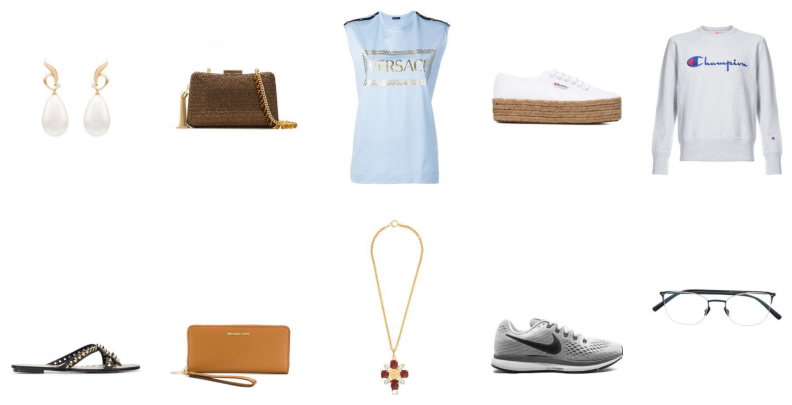


==============Model Images==============


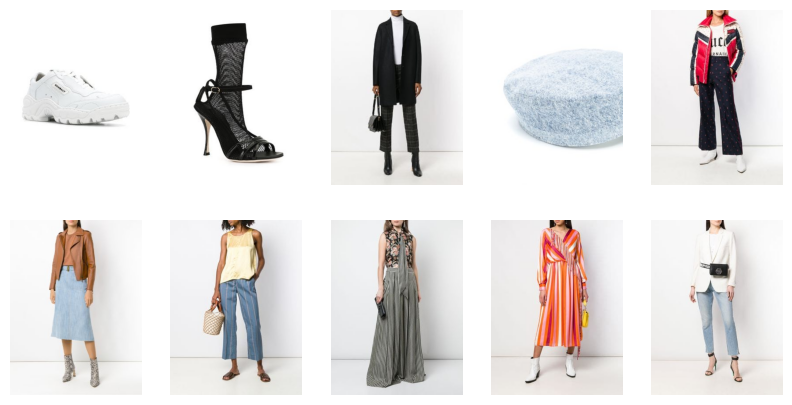

In [21]:
load_images()

In [22]:
# Join the images with path and add in the dataframe

# Store the directory path in a varaible
cutout_img_dir = "data/cutout"
model_img_dir = "data/model"

# list the directories
cutout_images = os.listdir(cutout_img_dir)
model_images = os.listdir(model_img_dir)

In [23]:
model_images[:10]

['10220378_1267228_300.jpg',
 '12990767_13697228_300.jpg',
 '13567906_16347254_300.jpg',
 '13716051_16819354_300.jpg',
 '13702605_16768220_300.jpg',
 '13687394_16638827_300.jpg',
 '13093776_14047281_300.jpg',
 '13534678_18104812_300.jpg',
 '13585622_16806036_300.jpg',
 '13887410_17825179_300.jpg']

In [26]:
def extractImageName(x):
    
    # 1. Invert the image path
    x_inv = x[ :: -1]
    
    # 2. Find the index of '/'
    slash_idx = x_inv.find('/')
    
    # 3. Extract the text after the -slash_idx
    return x[-slash_idx : ] 

listing_data['cutOutimageNames'] = listing_data['images.cutOut'].apply(lambda x : extractImageName(x))
listing_data['modelimageNames'] = listing_data['images.model'].apply(lambda x : extractImageName(x))

In [27]:
# Extract only those data points for which we have images
listing_data = listing_data[listing_data['cutOutimageNames'].isin(cutout_images)]
listing_data = listing_data[listing_data['modelimageNames'].isin(model_images)]

In [28]:
# Reset the index
listing_data.reset_index(drop=True, inplace=True)

In [29]:
# Add entire paths to cutOut and modelImages
listing_data['cutOutImages_path'] = cutout_img_dir + '/' + listing_data['cutOutimageNames']
listing_data['modelImages_path'] = model_img_dir + '/' + listing_data['modelimageNames']

In [30]:
# Drop the cutOutimageNames, cutOutimageNames
listing_data.drop(['cutOutimageNames', 'cutOutimageNames'], axis=1, inplace=True)

The images show a belted tailored trousers
Price: $888
Brand: Mm6 Maison Margiela



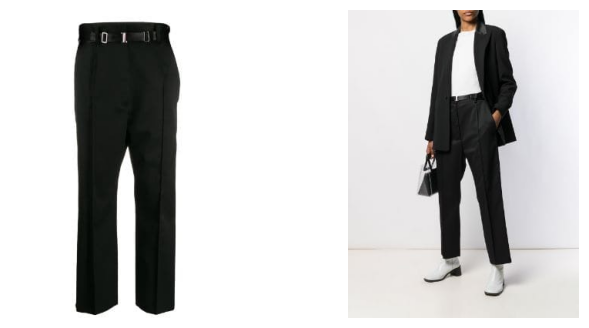

In [31]:
# Plot the images along with product descriptions, price and brand
random_idx = np.random.randint(low = 0, high = listing_data.shape[0] - 1)
cutOut_img_path = listing_data.iloc[random_idx]['cutOutImages_path']
model_img_path = listing_data.iloc[random_idx]['modelImages_path']
price = listing_data.iloc[random_idx]['priceInfo.formattedFinalPrice']
desc = listing_data.iloc[random_idx]['shortDescription']
brand = listing_data.iloc[random_idx]['brand.name']

# Load the images
cutOut_img = image.load_img(cutOut_img_path)
cutOut_img_arr = image.img_to_array(cutOut_img, dtype='int')
model_img = image.load_img(model_img_path)
model_img_arr = image.img_to_array(model_img, dtype='int')

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
print("The images show a {}".format(desc))
print("Price: {}".format(price))
print("Brand: {}".format(brand))
print()
ax[0].imshow(cutOut_img_arr)
ax[1].imshow(model_img_arr)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [32]:
def assign_product_category(description):
    label = list(description.split())[-1].lower()
    
    return label
listing_data['product_category']=listing_data["shortDescription"].map(lambda x: assign_product_category(x))

In [33]:
my_dict=dict()
for label in listing_data["product_category"]:
    try:
        my_dict[label]+=1
    except:
        my_dict[label]=1
choosen_category=[]
for key in my_dict.keys():
    if my_dict[key]>=100:
        choosen_category.append(key)

In [36]:
len(my_dict)

1683

In [37]:
def map_labels(label):
    # Khai báo các nhóm chính và các từ đồng nghĩa của chúng
    label_groups = {
        'matkinh': ['glasses', 'sunglasses'],
        'tatchan': ['socks'],
        'dongho': ['watch'],
        'dep': ['sandals', 'slides'],
        'giaycode': ['sneakers', 'boots', 'loafers', 'ballerinas', 'espadrilles', 'flats', 'trainers', 'booties', 'slippers', 'shoes'],
        'giaycaogot': ['pumps', 'mules'],
        'vi': ['wallet', 'purse', 'cardholder', 'holder'],
        'tuixach': ['bag', 'satchel', 'clutch', 'tote', 'pouch', 'handbag', 'crossbody'],
        'balo': ['backpack'],
        'daymockhoa': ['keyring'],
        'daydeo': ['strap'],
        'opdienthoai': ['case'],
        'aocanh': ['blouse', 'top', 'tunic'],
        'aophong': ['t-shirt', 'shirt'],
        'aolenni': ['sweater', 'cardigan', 'jumper', 'sweatshirt', 'pullover', 'hoodie'],
        'aongunu': ['camisole'],
        'quanaudai': ['trousers', 'pants', 'culottes', 'bottoms', 'bottom'],
        'quanjean': ['jeans'],
        'quanshort': ['shorts'],
        'vay': ['skirt', 'gown', 'dress'],
        'quanlegging': ['leggings'],
        'quanlot': ['briefs', 'thong'],
        'aokhoacdai': ['coat', 'blazer', 'parka', 'raincoat'],
        'aokhoangan': ['jacket', 'cape'],
        'aovest': ['vest', 'suit'],
        'aoghile': ['waistcoat', 'gilet'],
        'aochoang': ['poncho', 'shawl'],
        'aolotnguc': ['bra'],
        'bodysuit': ['bodysuit', 'body'],
        'jumpsuit': ['jumpsuit', 'playsuit'],
        'aoquanboi': ['swimsuit', 'bikini'],
        'khanco': ['scarf'],
        'mu': ['hat', 'cap'],
        'gangtay': ['gloves'],
        'caibangdau': ['headband'],
        'trangsucnho': ['hoops', 'ring', 'brooch', 'cuff', 'bangle', 'bracelet', 'earring', 'earrings'],
        'daychuyen': ['necklace', 'pendant'],
        'thatlung': ['belt'],
        'charm': ['charm'],
        'mulen': ['beanie'],
        'nen': ['candle'],
        'lythuytinh': ['glass'],
        'caidia': ['plate'],
        'unknown': ['detail', 'set']
    }
    
    # Kiểm tra từng nhóm và từng từ đồng nghĩa của nó
    for group, labels in label_groups.items():
        if label in labels:  # Nếu nhãn thuộc về nhóm đang xét
            return group  # Trả về tên nhóm tương ứng
    
    # Trả về nhãn ban đầu nếu không tìm thấy phù hợp
    return 'unknown'

In [34]:
sub_listing_data=listing_data[listing_data['product_category'].isin(choosen_category)]
sub_listing_data

brand.id     brand.name  gender  hasSimilarProducts        id  \
0           8360        Miu Miu   women                True  13415450   
1        2049368  Self-Portrait   women                True  13784566   
2          15514          Fendi   women                True  13377441   
3          49486         A.P.C.   women               False  13744082   
4          34624          Prada   women                True  13668256   
...          ...            ...     ...                 ...       ...   
188812     59394     Fornasetti  unisex               False  10047577   
188813     59394     Fornasetti  unisex               False  10047571   
188814     59394     Fornasetti  unisex               False  10047569   
188815     59394     Fornasetti  unisex               False  10047567   
188816     59394     Fornasetti  unisex               False  10047563   

                                            images.cutOut  \
0       https://cdn-images.farfetch-contents.com/13/41...   
1       https://cdn-images.farfetch-contents.com/13/78...   
2       https://cdn-images.farfetch-contents.com/13/37...   
3       https://cdn-images.farfetch-contents.com/13/74...   
4       https://cdn-images.farfetch-contents.com/13/66...   
...                                                   ...   
188812  https://cdn-images.farfetch-contents.com/10/04...   
188813  https://cdn-images.farfetch-contents.com/10/04...   
188814  https://cdn-images.farfetch-contents.com/10/04...   
188815  https://cdn-images.farfetch-contents.com/10/04...   
188816  https://cdn-images.farfetch-contents.com/10/04...   

                                             images.model  isCustomizable  \
0       https://cdn-images.farfetch-contents.com/13/41...           False   
1       https://cdn-images.farfetch-contents.com/13/78...           False   
2       https://cdn-images.farfetch-contents.com/13/37...           False   
3       https://cdn-images.farfetch-contents.com/13/74...           False   
4       https://cdn-images.farfetch-contents.com/13/66...           False   
...                                                   ...             ...   
188812  https://cdn-images.farfetch-contents.com/10/04...           False   
188813  https://cdn-images.farfetch-contents.com/10/04...           False   
188814  https://cdn-images.farfetch-contents.com/10/04...           False   
188815  https://cdn-images.farfetch-contents.com/10/04...           False   
188816  https://cdn-images.farfetch-contents.com/10/04...           False   

       merchandiseLabelField  merchantId  ... priceInfo.formattedFinalPrice  \
0                      NoTag        9359  ...                        $1,080   
1                      NoTag        9319  ...                          $392   
2                      NoTag        9140  ...                        $1,245   
3                      NoTag        9031  ...                          $308   
4                      NoTag        9339  ...                        $1,248   
...                      ...         ...  ...                           ...   
188812                 NoTag        9089  ...                          $207   
188813                 NoTag        9089  ...                          $207   
188814                 NoTag        9089  ...                          $207   
188815                 NoTag        9089  ...                          $207   
188816                 NoTag        9089  ...                          $207   

       priceInfo.formattedInitialPrice  priceInfo.initialPrice  \
0                               $1,080                    1080   
1                                 $490                     490   
2                               $1,245                    1245   
3                                 $385                     385   
4                               $1,248                    1248   
...                                ...                     ...   
188812                            $207                     207

In [47]:
# Creating a class for feature extraction and finding the most similar images

'''
Comparing 3 different models

1. VGG 16
2. ResNet 50
3. Xception
'''

class FeatureExtractor:
    
    # Constructor
    def __init__(self, arch='VGG'):
        
        self.arch = arch
        
        # Using VGG -16 as the architecture with ImageNet weights
        if self.arch == 'VGG' :
            base_model = VGG16(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
        
        # Using the ResNet 50 as the architecture with ImageNet weights
        elif self.arch == 'ResNet':
            base_model = ResNet50(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
        
        # Using the Xception as the architecture with ImageNet weights
        elif self.arch == 'Xception':
            base_model = Xception(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
            
    
    # Method to extract image features
    def extract_features(self, img):
        
        # The VGG 16 & ResNet 50 model has images of 224,244 as input while the Xception has 299, 299
        if self.arch == 'VGG' or self.arch == 'ResNet':
            img = img.resize((224, 224))
        elif self.arch == 'Xception':
            img = img.resize((299, 299))
        
        # Convert the image channels from to RGB
        img = img.convert('RGB')
        
        # Convert into array
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        if self.arch == 'VGG':
            # Proprocess the input as per vgg 16
            x = vgg_preprocess(x)
            
        elif self.arch == 'ResNet':
            # Proprocess the input as per ResNet 50
            x = resnet_preprocess(x)
            
        elif self.arch == 'Xception':
            # Proprocess the input as per ResNet 50
            x = xception_preprocess(x)
        
        
        # Extract the features
        features = self.model.predict(x) 
        
        # Scale the features
        features = features / np.linalg.norm(features)
        
        return features

In [26]:
# Extract the features for a sample of 10000 images
index_values = np.random.randint(low = 0, high = listing_data.shape[0]-1, size = 10000)
modelImages = listing_data.iloc[index_values]['modelImages_path']

In [27]:
# Create the model object and extract the features of top 10000 images (ResNet)
resnet_feature_extractor = FeatureExtractor(arch='ResNet')

# dictionary to store the features and index of the image
image_features_resnet = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    img = image.load_img(img_path)
    feature = resnet_feature_extractor.extract_features(img)
    image_features_resnet[idx] = feature

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/s

In [28]:
import pickle

pickle.dump(image_features_resnet, open("data/image_features_resnet.pkl", 'wb'))

In [50]:
# Create the model object and extract the features of top 10000 images (ResNet)
import pickle
resnet_feature_extractor = FeatureExtractor(arch='ResNet')

image_features_resnet = pickle.load(open("data/image_features_resnet.pkl","rb"))

In [29]:
# Create the model object and extract the features of top 10000 images (VGG 16)
vgg_feature_extractor = FeatureExtractor(arch='VGG')

# dictionary to store the features and index of the image
image_features_vgg = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    try:
        img = image.load_img(img_path)
        feature = vgg_feature_extractor.extract_features(img)
        image_features_vgg[idx] = feature
    except:
        print(idx)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━

In [30]:
import pickle

pickle.dump(image_features_vgg, open("data/image_features_vgg.pkl", 'wb'))

In [51]:
# Create the model object and extract the features of top 10000 images (ResNet)
import pickle
vgg_feature_extractor = FeatureExtractor(arch='VGG')

image_features_vgg = pickle.load(open("data/image_features_vgg.pkl","rb"))

In [31]:
# Create the model object and extract the features of top 1000 images (VGG 16)
xception_feature_extractor = FeatureExtractor(arch='Xception')

# dictionary to store the features and index of the image
image_features_xception = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    img = image.load_img(img_path)
    feature = xception_feature_extractor.extract_features(img)
    image_features_xception[idx] = feature

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [32]:
pickle.dump(image_features_xception, open("data/image_features_xception.pkl", 'wb'))

In [52]:
# Create the model object and extract the features of top 10000 images (ResNet)
import pickle
xception_feature_extractor = FeatureExtractor(arch='Xception')

image_features_xception = pickle.load(open("data/image_features_xception.pkl","rb"))

In [53]:
# Create a query
queryImage_idx = np.random.randint(low = 0, high = listing_data.shape[0] - 1)
queryImage_path = listing_data.iloc[queryImage_idx]['modelImages_path']
queryImage = image.load_img(queryImage_path)

# Extract Features from queryImage

# 1. ResNet
queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)

# 2. VGG 16
queryFeatures_Vgg = vgg_feature_extractor.extract_features(queryImage)

# 3. Xception
queryFeatures_Xception = xception_feature_extractor.extract_features(queryImage)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


In [54]:
# Compute Similarity between queryFeatures and every other image in image_features_vgg, image_features_resnet, image_features_xception

# 1. ResNet
similarity_images_resnet = {}
for idx, feat in image_features_resnet.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_resnet[idx] = np.sum((queryFeatures_Resnet - feat)**2) ** 0.5
    
similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]

# 2. VGG 16
similarity_images_vgg = {}
for idx, feat in image_features_vgg.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_vgg[idx] = np.sum((queryFeatures_Vgg - feat)**2) ** 0.5
    
similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted][ : 10]

# 3. Xception
similarity_images_xception = {}
for idx, feat in image_features_xception.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_xception[idx] = np.sum((queryFeatures_Xception - feat)**2) ** 0.5
    
similarity_xception_sorted = sorted(similarity_images_xception.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_xception = [idx for idx, _ in similarity_xception_sorted][ : 10]

========================================== QUERY IMAGE ===============================================


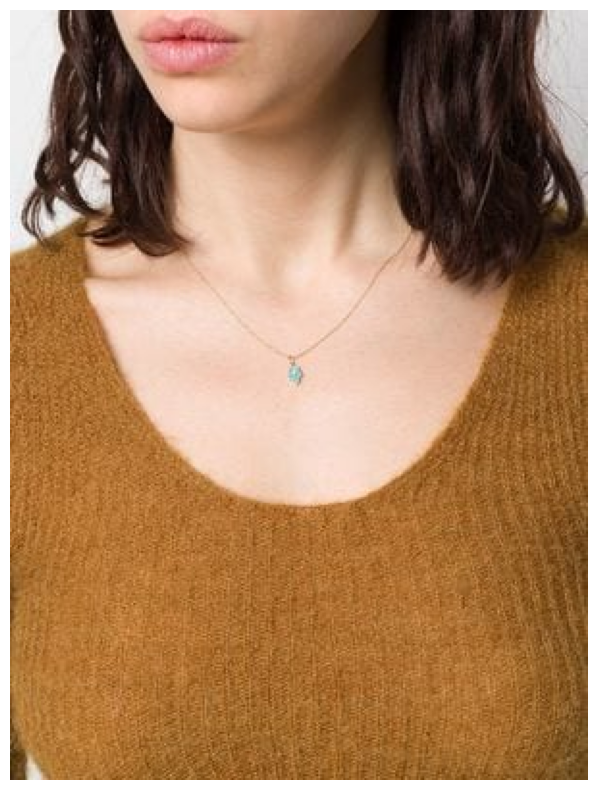


========================================== ResNet Results =============================================


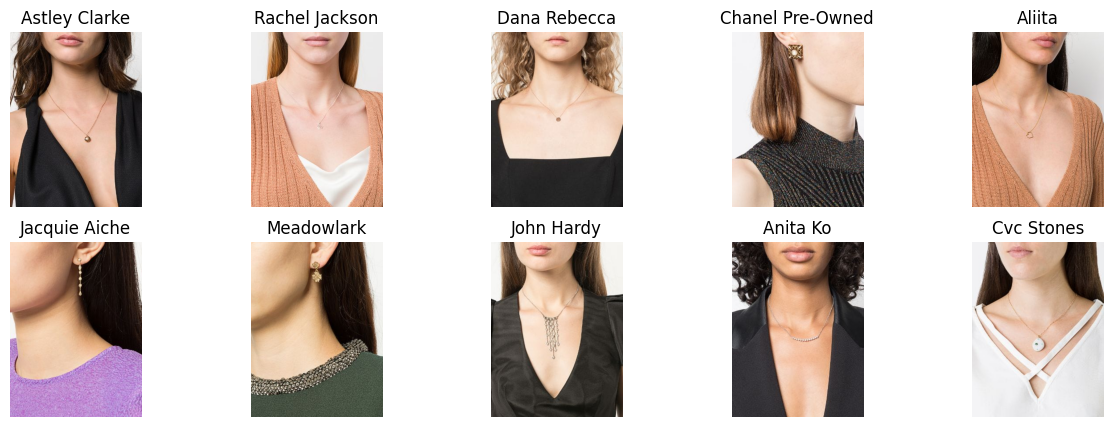



========================================== VGG 16 Results ============================================


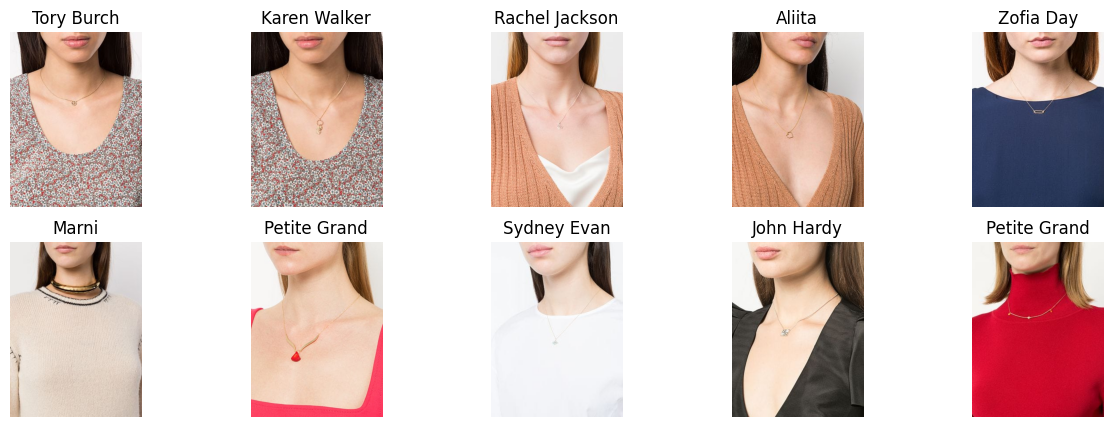



========================================== Xception Results ===========================================


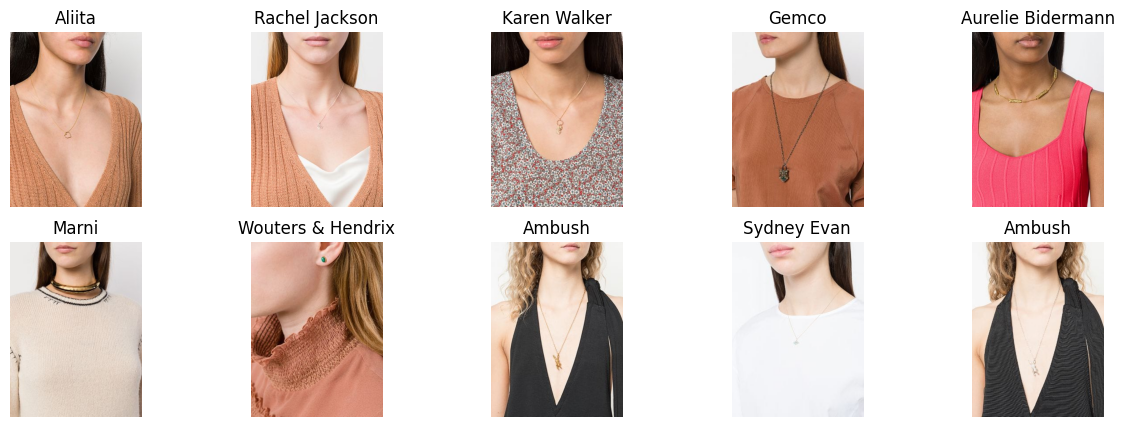

In [55]:
# Plot the results from all three models and prepare a comparison

print("========================================== QUERY IMAGE ===============================================")
plt.figure(figsize=(10,10))
plt.imshow(image.img_to_array(queryImage, dtype='int'))
plt.axis('off')
plt.show()
print("======================================================================================================")
print()

# 1. ResNet
top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']

# 2. VGG 16
top_10_similar_imgs_VGG = listing_data.iloc[top_10_indexes_vgg]['modelImages_path']
brand_VGG = listing_data.iloc[top_10_indexes_vgg]['brand.name']

# 3. Xception
top_10_similar_imgs_Xception = listing_data.iloc[top_10_indexes_xception]['modelImages_path']
brand_Xception = listing_data.iloc[top_10_indexes_xception]['brand.name']

print("========================================== ResNet Results =============================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Resnet, brand_Resnet)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off')
plt.show()
print("======================================================================================================")
print()
print()

print("========================================== VGG 16 Results ============================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_VGG, brand_VGG)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off')
plt.show()
print("======================================================================================================")
print()
print()

print("========================================== Xception Results ===========================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Xception, brand_Xception)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off') 
plt.show()
print("======================================================================================================")

In [56]:
def testModel(img_url):
    
    # Testing the architectures on external images
    
    '''Read the inserted url'''
    img_url = img_url
    response = requests.get(img_url)
    testing_img = Image.open(BytesIO(response.content))
    
    # Using the VGG 16 model to generate similar images
    testing_features = vgg_feature_extractor.extract_features(testing_img)
    
    similarity_images_vgg = {}
    for idx, feat in image_features_vgg.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_vgg[idx] = np.sum((testing_features - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_VGG = listing_data.iloc[top_10_indexes_vgg]['modelImages_path']
    brand_VGG = listing_data.iloc[top_10_indexes_vgg]['brand.name']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(8,8))
    testing_img_arr = image.img_to_array(testing_img, dtype='int')
    plt.imshow(testing_img_arr)
    plt.axis('off')
    plt.show()
    print("=============================================================")

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_VGG, brand_VGG)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
===================== QUERY IMAGE ==========================


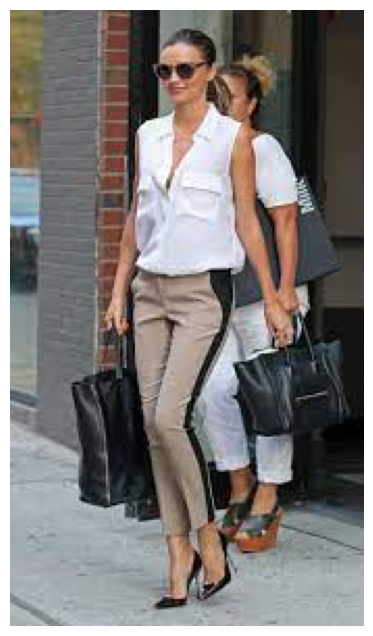

===================== SIMILAR IMAGES ==========================


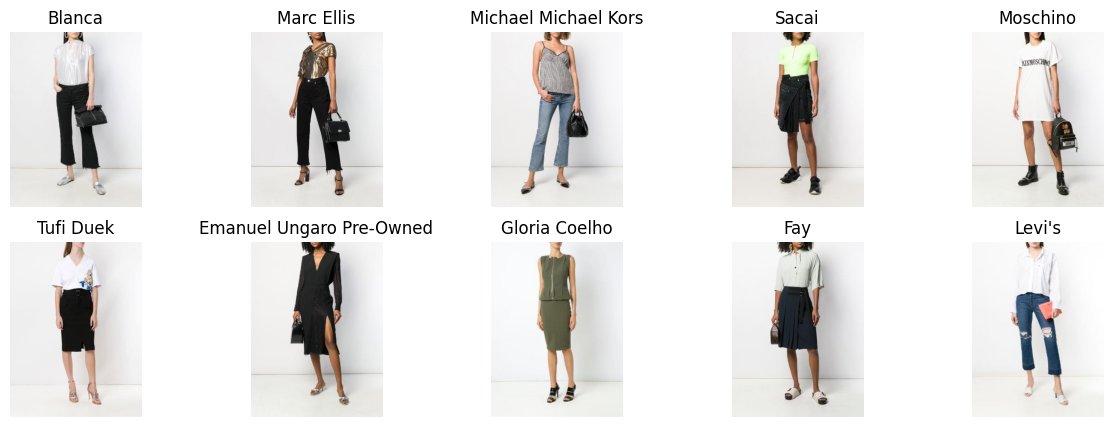

In [57]:
# Call the function
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS4wqVGRsgZeFnL9_gJXw2wTfdeRGFEmcKZtV2uvOqn5YYhL1XaHOcIYI1Ya4OFqhfz2kY&usqp=CAU"
testModel(img_url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
===================== QUERY IMAGE ==========================


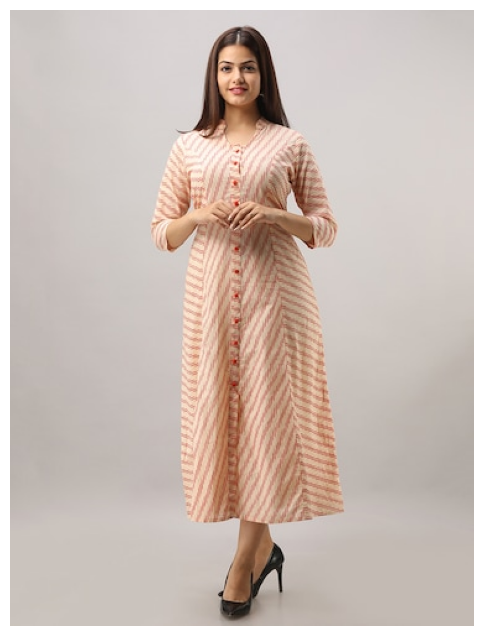

===================== SIMILAR IMAGES ==========================


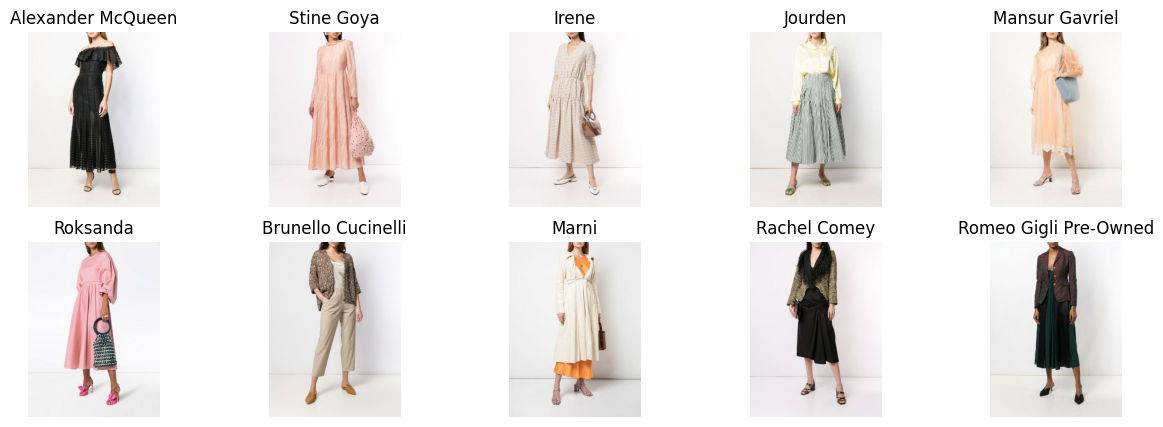

In [58]:
# Call the function
img_url = "https://img3.junaroad.com/uiproducts/16642282/pri_175_p-1598456961.jpg"
testModel(img_url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
===================== QUERY IMAGE ==========================


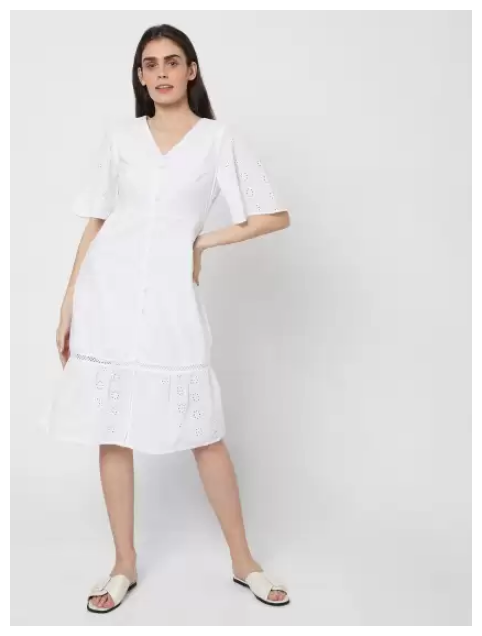

===================== SIMILAR IMAGES ==========================


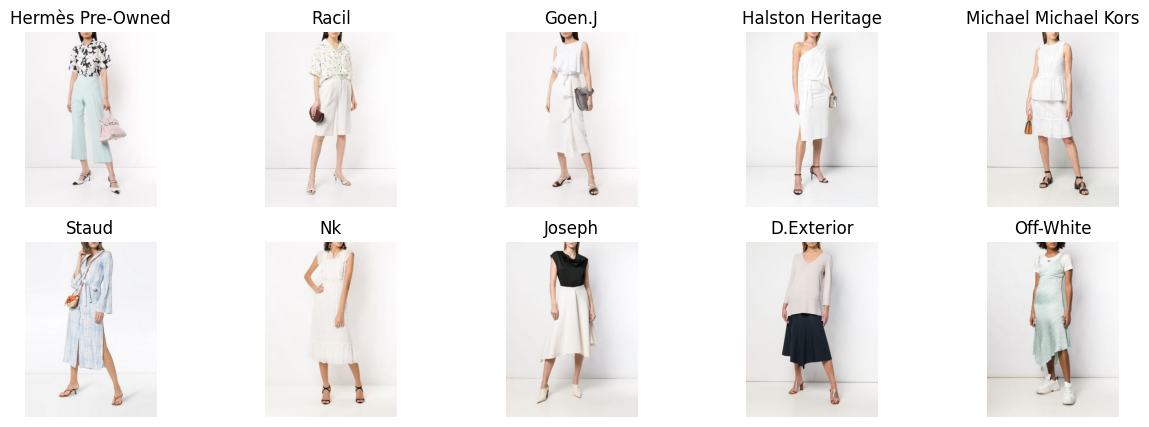

In [59]:
# Call the function
img_url = "https://assets.myntassets.com/f_webp,dpr_2.0,q_60,w_210,c_limit,fl_progressive/assets/images/16517990/2021/12/14/186c22ac-5678-401e-a491-f2f9d58b8aee1639492696377VeroModaWhiteA-LineDress1.jpg"
testModel(img_url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
===================== QUERY IMAGE ==========================


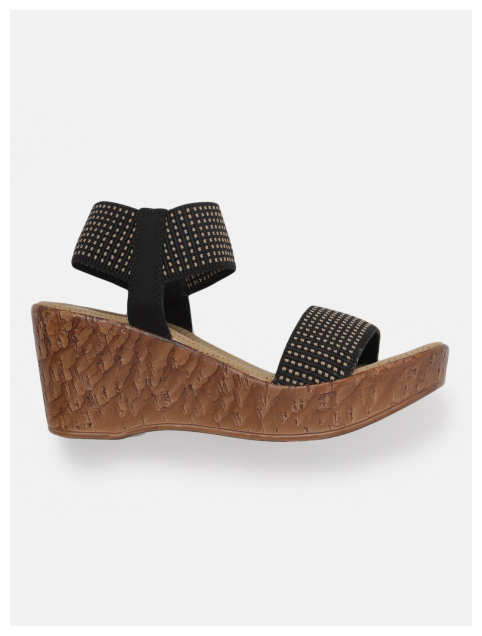

===================== SIMILAR IMAGES ==========================


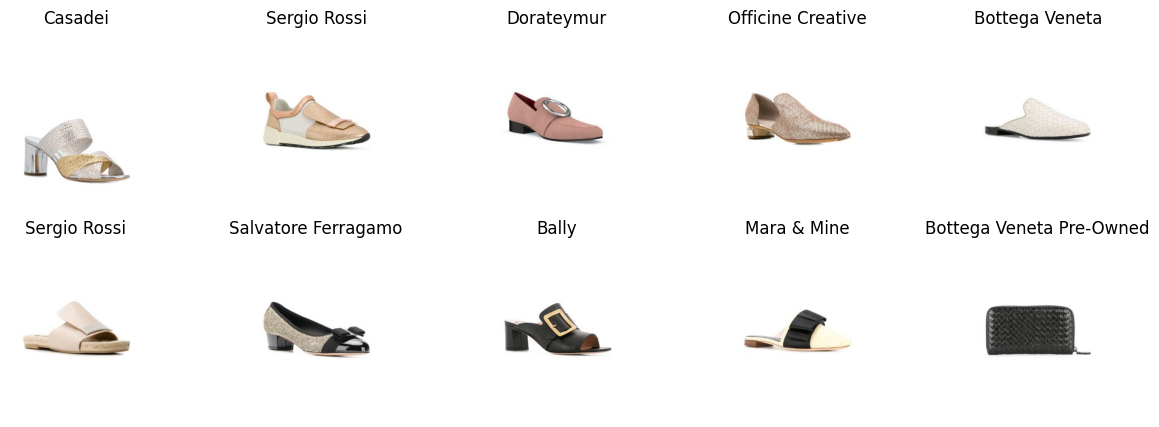

In [60]:
# Call the function
img_url = "https://assets.myntassets.com/h_1440,q_90,w_1080/v1/assets/images/8607853/2021/10/27/3dc9c459-0a09-4a64-8656-c61e762ddb2f1635331357142CatwalkWomenBlackBeigeSolidSandals2.jpg"
testModel(img_url)